In [1]:
#import library
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

In [2]:
#class algoritma klasifikasi Fuzzy K-Nearest Neighbor
class FuzzyKNN(BaseEstimator, ClassifierMixin):
    #function inisialisasi
    def __init__(self, k, plot=False):
        self.k = k
        self.plot = plot
        
    #mengecek parameter yang dimasukkan apakah sudah sesuai sebelum menggunakan algoritma FKNN
    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
            
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')
        
    #melatih/membuat model berdasarkan data train yang dimasukkan
    def fit(self, X, y=None):
        self._check_params(X,y) #memanggil fungsi check_parameter
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        
        classes = list(set(y))
        classes.sort()
        self.classes = classes
        
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        
        self.memberships = self._compute_memberships() #memanggil fungsi compute membership
        
        self.df['membership'] = self.memberships
        
        self.fitted_ = True
        return self
    
    #memprediksi data baru (testing) masuk ke dalam class mana
    def predict(self, X, m):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            y_pred = []
            
            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
                
                votes = {}
                for c in self.classes:
                    den = 0
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        den += 1 / (dist ** (2 / (m-1)))
                    
                    neighbors_votes = []
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        num = (neighbors.iloc[n].membership[c]) / (dist ** (2 / (m-1)))
                        
                        vote = num/den
                        neighbors_votes.append(vote)
                    votes[c] = np.sum(neighbors_votes)
                    
                pred = max(votes.items(), key=operator.itemgetter(1))[0]
                y_pred.append((pred, votes))
                
            return y_pred
        
    #menampilkan nilai akurasi dari model yang sudah dibuat
    def score(self, X, y, m):
        if self.fitted_ == None:
            raise Exception('score() called before fit()')
        else:
            predictions = self.predict(X, m)
            y_pred = [t[0] for t in predictions]
            confidences = [t[1] for t in predictions]
            
            return accuracy_score(y_pred=y_pred, y_true=y)
    
    #mencari tetangga terdekat berdasarkan K
    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values
        
        df['distances'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]
        
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

    #menentukan hasil tetangga terdekat dari proses function find KNN        
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        
        return counts
        
    #menghitung inisialisasi fuzzy untuk menghitung nilai keanggotaannya
    def _compute_memberships(self):
        memberships = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y[i]
            
            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x) #memanggil fungsi find_knn
            counts = self._get_counts(neighbors)
        
            membership = dict()
            for c in self.classes:
                try:
                    #rumus inisialisasi fuzzy
                    uci = 0.49 * (counts[c] / self.k)
                    if c == y:
                        uci += 0.51
                    membership[c] = uci
                except:
                    membership[c] = 0
                    
            memberships.append(membership)
        return memberships

In [3]:
def oversample(df):
    classes = df.KK.value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['KK'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

# Mencari split data train dan test terbaik

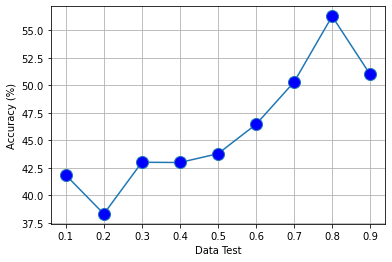

In [4]:
iterasi_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
accuracy = []
#import data train dan test yang akan digunakan

# #unblock jika tidak terdapat data train (data train dengan undersample baru mempengaruhi hasilnya)
#data_train = pd.read_csv('csv/data_train1617.csv')
#data_train = oversample(data_train)
#data_train.to_csv('csv/data_train_oversample.csv', index = False)

data_train = pd.read_csv('csv/data_train_oversample.csv')
data_test = pd.read_csv('csv/data_test18.csv')

mk = data_train
mk = mk.drop(["KK"], axis=1)
mk = mk.to_numpy()

kk = data_train["KK"]
kk = kk.astype(int)
kk = kk.to_numpy()

test = data_test
test1 = test
test = test.to_numpy()

for ukuran_test in iterasi_test:
    X = mk
    y = kk

    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = ukuran_test, random_state = 42)
    
    FuzzyKNN_Model = FuzzyKNN(5)
    FuzzyKNN_Model.fit(xTrain, yTrain)
    hasil = 100 * FuzzyKNN_Model.score(xTest, yTest, m = 4)
    accuracy.append(hasil)

#mengambil split data terbaik berdasarkan nilai akurasi tertinggi yang didapat 
i = accuracy[0]
idx = 0
index = 0
for value in accuracy:
    if i < value:
        i = value
        index = idx
    idx = idx + 1
        
ukuran_test_terbaik = iterasi_test[index]

plt.plot(iterasi_test, accuracy, marker='o', markerfacecolor='blue', markersize=12)

plt.title('')
plt.xlabel('Data Test')
plt.ylabel('Accuracy (%)')

plt.grid()
 
plt.show()

In [5]:
accuracy

[41.84782608695652,
 38.315217391304344,
 43.01270417422868,
 42.993197278911566,
 43.790849673202615,
 46.46098003629764,
 50.311041990668734,
 56.29680054458815,
 50.99818511796733]

# Mencari nilai K terbaik

In [6]:
X = mk
y = kk

xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size=ukuran_test_terbaik, random_state = 42) #menggunakan test size terbaik dari evaluasi sebelumnya

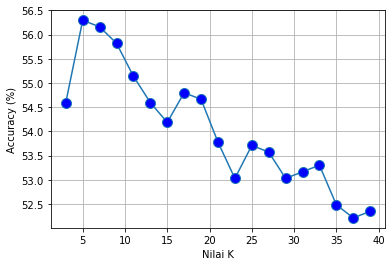

In [7]:
iterasi_k = [3, 5, 7 , 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]
accuracy = []

for k in iterasi_k:
    FuzzyKNN_Model = FuzzyKNN(k)
    FuzzyKNN_Model.fit(xTrain, yTrain)
    hasil = 100 * FuzzyKNN_Model.score(xTest, yTest, 4)
    accuracy.append(hasil)
    
i = accuracy[0]
idx = 0
index = 0
for value in accuracy:
    if i < value:
        i = value
        index = idx
    idx = idx + 1
        
nilai_k_terbaik = iterasi_k[index]
    
plt.plot(iterasi_k, accuracy, marker='o', markerfacecolor='blue', markersize=10)

plt.title('')
plt.xlabel('Nilai K')
plt.ylabel('Accuracy (%)')

plt.grid()

plt.show()

In [8]:
accuracy

[54.59496255956433,
 56.29680054458815,
 56.16065350578625,
 55.820285908781486,
 55.13955071477196,
 54.59496255956433,
 54.18652144315861,
 54.79918311776719,
 54.66303607896529,
 53.7780803267529,
 53.02927161334241,
 53.71000680735194,
 53.57385976855004,
 53.02927161334241,
 53.16541865214431,
 53.30156569094622,
 52.48468345813478,
 52.21238938053098,
 52.34853641933288]

# Perbandingan Dengan Algoritma Lain

In [9]:
iterasi = [1,2,3,4,5,6,7,8,9,10]
accuracy = []

X = mk
y = kk

xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size=ukuran_test_terbaik, random_state = 42) #menggunakan test size terbaik dari evaluasi sebelumnya

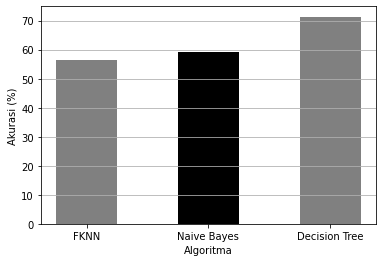

In [10]:
#evaluasi menampilkan nilai akurasi terbaik dari beberapa algoritma klasifikasi
bar = [1, 2, 3]
accuracy = []

#algoritma FKNN
FuzzyKNN_Model = FuzzyKNN(nilai_k_terbaik)
FuzzyKNN_Model.fit(xTrain, yTrain)
hasil = 100 * FuzzyKNN_Model.score(xTest, yTest, m = 4)
accuracy.append(hasil)

NaiveBayes_Model = GaussianNB()
NaiveBayes_Model.fit(xTrain, yTrain)
hasil = 100 * NaiveBayes_Model.score(xTest, yTest)
accuracy.append(hasil)

DecisionTree_Model = tree.DecisionTreeClassifier()
DecisionTree_Model.fit(xTrain, yTrain)
hasil = 100 * DecisionTree_Model.score(xTest, yTest)
accuracy.append(hasil)
 
tick_label = ['FKNN', 'Naive Bayes', 'Decision Tree']
 
plt.bar(bar, accuracy, tick_label = tick_label,
        width = 0.5, color = ['grey', 'black', 'grey'])
 
plt.xlabel('Algoritma')
plt.ylabel('Akurasi (%)')
plt.grid(axis = 'y')

# function to show the plot
plt.show()

In [11]:
accuracy

[56.29680054458815, 59.08781484002723, 71.34104833219878]

In [12]:
#evaluasi hasil (akurasi, precision, recall, f1score) dari beberapa algoritma sebagai pembanding
#algoritma FKNN
prediction = []
Pred = FuzzyKNN_Model.predict(xTest, m = 4)
for index in Pred:
    prediction.append(index[0])
print("Fuzzy KNN")
print(classification_report(yTest, prediction))

#algoritma Naive Bayes
Pred = NaiveBayes_Model.predict(xTest)
print("Naive Bayes")
print(classification_report(yTest, Pred))

#algoritma Decision Tree
Pred = DecisionTree_Model.predict(xTest)
print("Decision Tree")
print(classification_report(yTest, Pred))

Fuzzy KNN
              precision    recall  f1-score   support

           0       0.44      0.85      0.58       370
           1       0.71      0.61      0.66       351
           2       0.62      0.28      0.39       370
           3       0.69      0.51      0.59       378

    accuracy                           0.56      1469
   macro avg       0.62      0.56      0.55      1469
weighted avg       0.61      0.56      0.55      1469

Naive Bayes
              precision    recall  f1-score   support

           0       0.58      0.41      0.48       370
           1       0.64      0.53      0.58       351
           2       0.64      0.63      0.64       370
           3       0.53      0.78      0.63       378

    accuracy                           0.59      1469
   macro avg       0.60      0.59      0.58      1469
weighted avg       0.60      0.59      0.58      1469

Decision Tree
              precision    recall  f1-score   support

           0       0.71      0.69      

# Hasil Prediksi Pada Data Validasi

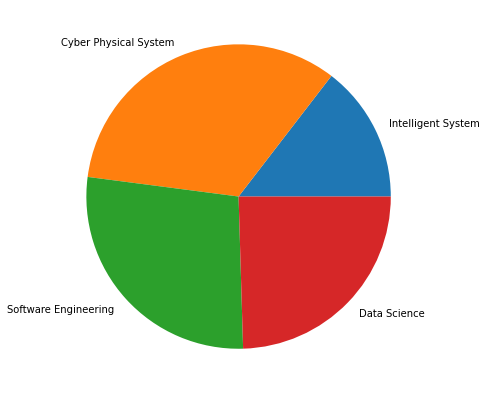

Intelligent System    =  92 ( 15% )
Cyber Physical System =  211 ( 33% )
Software Engineering  =  174 ( 28% )
Data Science          =  155 ( 25% )


In [13]:
#menampilkan isi dari hasil prediksi data testing
yPred = FuzzyKNN_Model.predict(test,m = 4)

#mengubah penulisan pada kolok Kelompok Keahlian dari numerik menjadi kalimat
hasil = []

for index in yPred:
    hasil.append(index[0])

hasil = pd.DataFrame(hasil)
hasil = hasil.rename(columns={0:"KK"})

hasil['KK'] = hasil['KK'].replace(to_replace = 0, value = 'Intelligent System')
hasil['KK'] = hasil['KK'].replace(to_replace = 1, value = 'Cyber Physical System')
hasil['KK'] = hasil['KK'].replace(to_replace = 2, value = 'Software Engineering')
hasil['KK'] = hasil['KK'].replace(to_replace = 3, value = 'Data Science')
        
#melakukan pengecekkan banyaknya mahasiswa pada setiap Kelompok Keahlian pada hasil prediksi (data testing)
IS = 0
CPS = 0
SE = 0
DS = 0

for index, row in test1.iterrows():
    if yPred[index][0] == 0:
        IS = IS + 1
    elif yPred[index][0] == 1:
        CPS = CPS + 1
    elif yPred[index][0] == 2:
        SE = SE + 1
    elif yPred[index][0] == 3:
        DS = DS + 1

kelompok_keahlian = ["Intelligent System","Cyber Physical System","Software Engineering","Data Science"]
data_kk_mahasiswa18 = [IS,CPS,SE,DS]

fig = plt.figure(figsize =(10, 7))
plt.pie(data_kk_mahasiswa18, labels = kelompok_keahlian)

plt.show()
print('Intelligent System    = ', IS, '(',"{:.0%}".format(IS/sum(data_kk_mahasiswa18)),')')
print('Cyber Physical System = ', CPS, '(',"{:.0%}".format(CPS/sum(data_kk_mahasiswa18)),')')
print('Software Engineering  = ', SE, '(',"{:.0%}".format(SE/sum(data_kk_mahasiswa18)),')')
print('Data Science          = ', DS, '(',"{:.0%}".format(DS/sum(data_kk_mahasiswa18)),')')

In [14]:
#memasukkan / menggabungkan hasil prediksi ke dalam dataset data testing
df_KK_18 = pd.concat([test1, hasil], axis=1)
df_KK_18
df_KK_18.to_csv('csv/data_hasil_prediksi_s1', index = False)
df_KK_18

,LOGIKA MATEMATIKA,MATEMATIKA DISKRIT,ALGORITMA PEMROGRAMAN,ANALISIS KOMPLEKSITAS ALGORITMA,STRUKTUR DATA,PENGANTAR KECERDASAN BUATAN,TEORI BAHASA DAN AUTOMATA,PEMBELAJARAN MESIN,PEMROGRAMAN BERORIENTASI OBJEK,SISTEM DIGITAL,...,PEMODELAN BASIS DATA,RPL: ANALISIS KEBUTUHAN,SISTEM BASIS DATA,INTERAKSI MANUSIA KOMPUTER,KALKULUS,STATISTIKA,KALKULUS LANJUT,MATRIKS DAN RUANG VEKTOR,TEORI PELUANG,KK
0,1.0,0.0,3.5,0.0,2.0,0.0,1.0,0.0,3.5,3.0,...,2.0,0.0,0.0,0.0,1.0,3.5,0.0,0.0,0.0,Software Engineering
1,4.0,4.0,3.5,3.5,3.0,3.0,3.5,4.0,3.5,4.0,...,3.5,4.0,2.5,3.5,4.0,4.0,4.0,3.5,3.5,Data Science
2,2.5,2.0,3.0,2.5,3.0,3.0,2.0,3.5,3.0,3.5,...,2.5,4.0,2.0,3.0,2.0,3.5,1.0,2.5,2.5,Software Engineering
3,2.0,2.0,1.0,2.0,2.0,4.0,1.0,4.0,2.0,3.5,...,2.0,2.5,2.0,3.5,2.0,4.0,1.0,3.5,2.5,Cyber Physical System
4,3.5,4.0,2.5,2.5,2.5,4.0,3.0,3.5,3.5,3.5,...,3.0,3.5,3.5,3.5,4.0,4.0,4.0,4.0,3.0,Data Science
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,1.0,3.0,2.0,2.0,2.0,4.0,3.0,4.0,3.0,4.0,...,2.0,2.5,2.5,4.0,2.5,3.0,4.0,2.0,4.0,Cyber Physical System
628,2.0,3.5,2.5,2.0,4.0,4.0,3.0,4.0,3.0,4.0,...,3.5,1.0,3.5,3.5,2.0,4.0,1.0,1.0,2.0,Intelligent System
629,2.5,3.5,3.0,2.5,2.0,2.0,3.0,4.0,2.5,3.0,...,3.0,2.0,1.0,3.5,3.5,4.0,3.5,2.0,1.0,Cyber Physical System
630,2.5,3.0,4.0,3.0,3.0,4.0,2.5,4.0,4.0,3.5,...,3.5,4.0,3.0,3.5,1.0,3.5,1.0,1.0,2.5,Intelligent System


# Mencek nilai akurasi menggunakan Cross Validation Score

In [15]:
#class algoritma klasifikasi Fuzzy K-Nearest Neighbor
class FuzzyKNN(BaseEstimator, ClassifierMixin):
    #function inisialisasi
    def __init__(self, k=nilai_k_terbaik, plot=False): #banyaknya k
        self.k = k
        self.plot = plot
        
    #mengecek parameter yang dimasukkan apakah sudah sesuai sebelum menggunakan algoritma FKNN
    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')
            
        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')
        
    #melatih/membuat model berdasarkan data train yang dimasukkan
    def fit(self, X, y=None):
        self._check_params(X,y) #memanggil fungsi check_parameter
        self.X = X
        self.y = y
        
        self.xdim = len(self.X[0])
        self.n = len(y)
        
        classes = list(set(y))
        classes.sort()
        self.classes = classes
        
        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y
        
        self.memberships = self._compute_memberships() #memanggil fungsi compute membership
        
        self.df['membership'] = self.memberships
        
        self.fitted_ = True
        return self
    
    #memprediksi data baru (testing) masuk ke dalam class mana
    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            m = 4 #menentukan faktor skala dalam pembobotan
            y_pred = []
            
            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
                
                votes = {}
                for c in self.classes:
                    den = 0
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        den += 1 / (dist ** (2 / (m-1)))
                    
                    neighbors_votes = []
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        num = (neighbors.iloc[n].membership[c]) / (dist ** (2 / (m-1)))
                        
                        vote = num/den
                        neighbors_votes.append(vote)
                    votes[c] = np.sum(neighbors_votes)
                    
                pred = max(votes.items(), key=operator.itemgetter(1))[0]
                y_pred.append((pred, votes))
                
            return y_pred
        
    #menampilkan nilai akurasi dari model yang sudah dibuat
    def score(self, X, y):
        if self.fitted_ == None:
            raise Exception('score() called before fit()')
        else:
            predictions = self.predict(X)
            y_pred = [t[0] for t in predictions]
            confidences = [t[1] for t in predictions]
            
            return accuracy_score(y_pred=y_pred, y_true=y)
    
    #mencari tetangga terdekat berdasarkan K
    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values
        
        df['distances'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]
        
        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]
        
        return neighbors

    #menentukan hasil tetangga terdekat dari proses function find KNN        
    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}
        
        return counts
        
    #menghitung inisialisasi fuzzy untuk menghitung nilai keanggotaannya
    def _compute_memberships(self):
        memberships = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y[i]
            
            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x) #memanggil fungsi find_knn
            counts = self._get_counts(neighbors)
        
            membership = dict()
            for c in self.classes:
                try:
                    #rumus inisialisasi fuzzy
                    uci = 0.49 * (counts[c] / self.k)
                    if c == y:
                        uci += 0.51
                    membership[c] = uci
                except:
                    membership[c] = 0
                    
            memberships.append(membership)
        return memberships

In [16]:
#cross_validation_score
#function menghitung nilai rata-rata pada cross validation score
def rata_rata(arra,cv):
    total = 0
    
    for i in arra:
        total = total + i
    total = (total / cv) * 100
    
    return(total)

#evaluasi menghitung nilai akurasi yang didapat menggunakan metode cross validation score
FuzzyKNN_Model = FuzzyKNN()
FuzzyKNN_Model.fit(xTrain, yTrain)
score = cross_val_score(cv=5, estimator=FuzzyKNN_Model, X = xTest, y = yTest)
print("Fuzzy K Neighbour      = ", score)
print("Rata - rata = ", rata_rata(score,5))
print(" ")

score = cross_val_score(cv=5, estimator=NaiveBayes_Model, X=xTest, y=yTest)
print("Naive Bayes = ", score)
print("Rata - rata = ", rata_rata(score,5))
print(" ")

score = cross_val_score(cv=5, estimator=DecisionTree_Model, X=xTest, y=yTest)
print("Decision Tree = ", score)
print("Rata - rata = ", rata_rata(score,5))

Fuzzy K Neighbour      =  [0.39455782 0.44557823 0.45578231 0.39795918 0.41979522]
Rata - rata =  42.27345545726823
 
Naive Bayes =  [0.65646259 0.65306122 0.67006803 0.64285714 0.6894198 ]
Rata - rata =  66.23737549627359
 
Decision Tree =  [0.8537415  0.84353741 0.87755102 0.8707483  0.8668942 ]
Rata - rata =  86.24944858489471


In [17]:
data_train.KK.value_counts()

3.0    459
0.0    459
2.0    459
1.0    459
Name: KK, dtype: int64

In [18]:
ukuran_test_terbaik

0.8

In [19]:
nilai_k_terbaik

5

In [20]:
data_train = pd.read_csv('csv/data_train_oversample.csv')

In [21]:
data_train

,LOGIKA MATEMATIKA,MATEMATIKA DISKRIT,ALGORITMA PEMROGRAMAN,ANALISIS KOMPLEKSITAS ALGORITMA,STRUKTUR DATA,PENGANTAR KECERDASAN BUATAN,TEORI BAHASA DAN AUTOMATA,PEMBELAJARAN MESIN,PEMROGRAMAN BERORIENTASI OBJEK,SISTEM DIGITAL,...,PEMODELAN BASIS DATA,RPL: ANALISIS KEBUTUHAN,SISTEM BASIS DATA,INTERAKSI MANUSIA KOMPUTER,KALKULUS,STATISTIKA,KALKULUS LANJUT,MATRIKS DAN RUANG VEKTOR,TEORI PELUANG,KK
0,3.5,4.0,4.0,2.5,2.5,3.5,3.0,3.5,3.5,2.0,...,3.5,4.0,3.0,3.5,4.0,4.0,4.0,3.5,3.5,3.0
1,3.5,4.0,3.5,2.5,2.0,4.0,2.5,3.5,2.5,4.0,...,2.5,3.0,3.5,3.5,4.0,4.0,4.0,4.0,4.0,3.0
2,4.0,3.5,3.0,1.0,3.0,3.5,3.5,4.0,4.0,3.0,...,3.5,3.0,2.0,3.5,4.0,3.5,3.5,3.0,4.0,3.0
3,4.0,3.5,2.5,2.5,2.0,4.0,4.0,3.5,4.0,4.0,...,4.0,3.5,3.0,3.5,4.0,4.0,4.0,3.5,3.5,3.0
4,3.5,4.0,3.5,3.5,2.0,2.0,2.0,3.5,3.5,2.5,...,3.0,3.5,3.0,2.5,4.0,4.0,4.0,3.5,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,4.0,4.0,1.0,2.0,2.5,3.5,3.5,3.0,4.0,3.5,...,3.5,3.5,1.0,3.5,3.5,4.0,4.0,3.5,3.0,1.0
1832,4.0,3.5,4.0,3.5,4.0,3.0,4.0,3.5,4.0,4.0,...,4.0,4.0,3.5,4.0,4.0,4.0,2.5,3.0,4.0,1.0
1833,4.0,4.0,3.5,3.5,3.0,4.0,3.5,4.0,3.5,4.0,...,3.0,3.5,4.0,3.5,4.0,4.0,4.0,3.5,4.0,1.0
1834,2.5,3.0,1.0,3.5,2.5,3.5,3.5,3.5,1.0,4.0,...,2.5,3.5,3.0,2.5,2.5,4.0,2.5,2.5,3.0,1.0
